----------------------
# <center>TP 6 : Bagging, Random Forests, Boosting</center>
----------------------
*Thomas Koch*

In [60]:
import math 
import numpy as np
from sklearn import linear_model
from sklearn.utils import shuffle as sh
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
import sklearn.datasets
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import zero_one_loss
from sklearn.ensemble import AdaBoostClassifier

from os import mkdir
from os import path 

import pandas as pd
import urllib
import zipfile

import matplotlib.dates as mdates
import matplotlib.lines as mlines
from matplotlib.gridspec import GridSpec

from scipy.stats import binom

In [144]:
# Show the graphs here
%pylab inline

# Configuration
pylab.rcParams['figure.figsize'] = (15,10) # figures sizes
import matplotlib.pyplot as plt
plt.style.use('seaborn') # Chose ggplot instead of seaborn

lw = 2.5 # linewidth in all graphics
sc = 50 # Scatter size
alp=0.7

Populating the interactive namespace from numpy and matplotlib


In [62]:

# Colors
c_tree = "deepskyblue"
c_bagging = "mediumvioletred"
c_bagging_bt = "limegreen"

c_rf = "palevioletred"
c_svm = "mediumseagreen"
c_dt = "limegreen"

c_train = "teal"
c_test = "darkslateblue"

c_train_adaboost = "turquoise"
c_test_adaboost = "lightsteelblue"

## <center>*- Agrégation de modèle -*</center>

### Question 1 :
Si $p = 0.7$ (ce qui est une prédiction faiblement au dessus de la chance à $0.5$) et $L = 1, 5, 10, 50, 100$, quelle est la probabilité de prédiction correcte pour le modèle agrégé ? Pour $L = 10$ choisi, tracez
les probabilités de la classification correct pour chaque nombre de classifieurs $1, 2, ..., 10$. On pourra s’aider de l’implémentation de la distribution Binomiale dans scipy :
```python
from scipy.stats import binom
rv = binom(L, p)
```
Le problème en pratique est que les données ne sont fournies qu’une seule fois. Il faut donc arriver à générer de l’aléatoire.

In [55]:
p = 0.7
L = np.array([1, 5, 10, 50, 100])
rv = binom(L, p)

mean, var, skew, kurt = binom.stats(L, p, moments='mvsk')

In [56]:
mean

array([ 0.7,  3.5,  7. , 35. , 70. ])

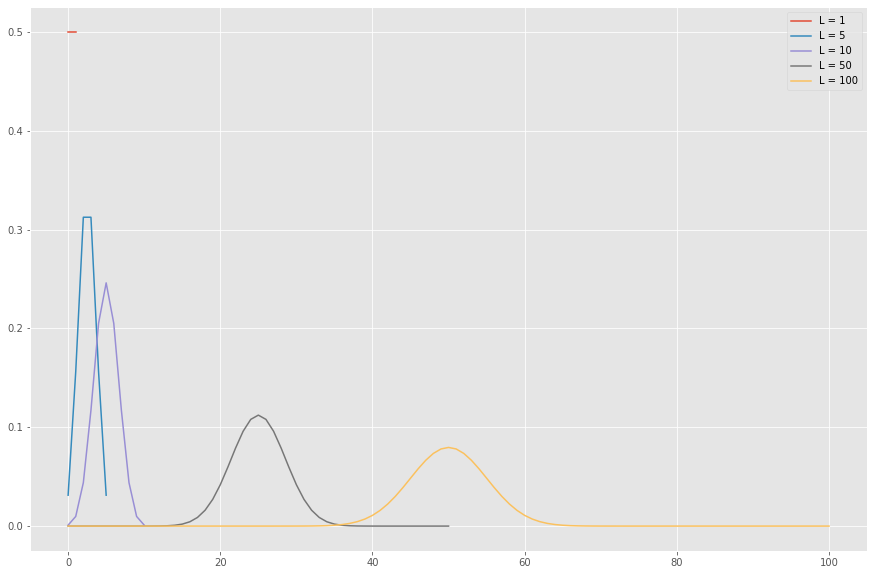

In [98]:
L = [1, 5, 10, 50, 100]
p = 0.5
for i in range(0, 5) :
    x = np.array(range(L[i]+1))
    x_norm = x / L[i]

    y = [binom.pmf(k, L[i], p, loc=0) for k in range(L[i]+1)]
    #plt.subplot(211)
    plt.plot(x, y, label = 'L = '+ str(L[i]))
    plt.legend()


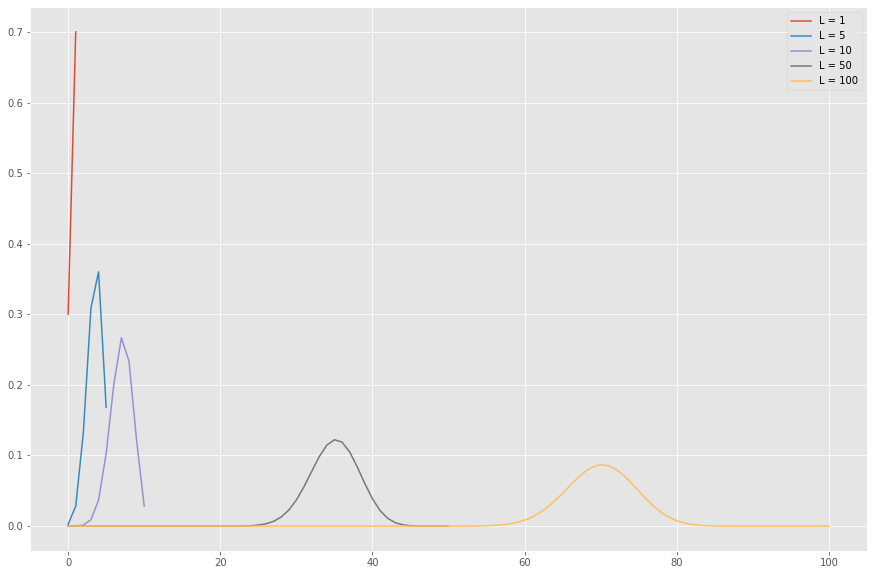

In [99]:
p = 0.7
for i in range(0, 5) :
    x = np.array(range(L[i]+1))
    x_norm = x / L[i]

    y = [binom.pmf(k, L[i], p, loc=0) for k in range(L[i]+1)]
    #plt.subplot(212)
    plt.plot(x, y, label = 'L = '+ str(L[i]))
    plt.legend()

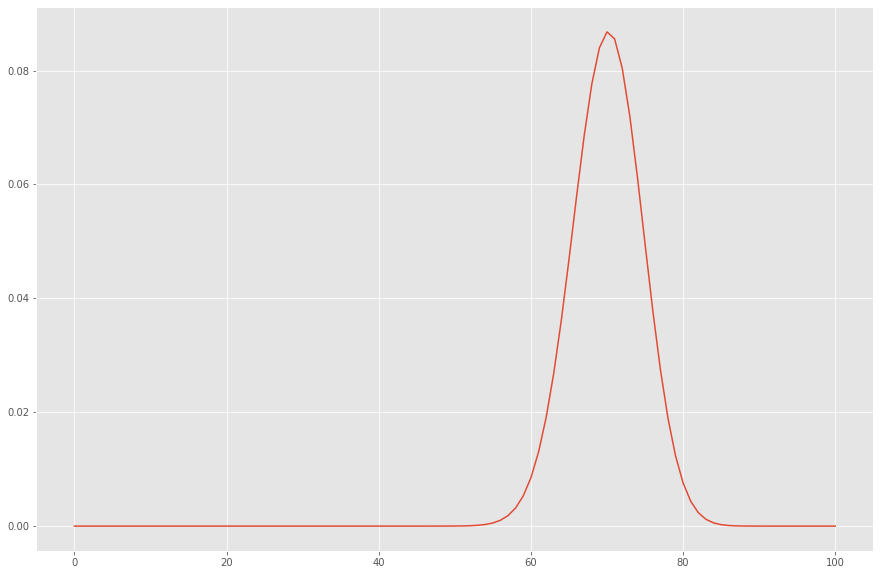

In [100]:
L = 100
x = np.array(range(L+1))
x_norm = x / L

y = [binom.pmf(k, L, p, loc=0) for k in range(L+1)]
plt.plot(x, y)

## <center>*- Bagging -*</center>

Le *Bagging* (acronyme venant de "Boostrap Aggregation") est une méthode classique pour combiner les modèles. Elle consiste à prendre une simple moyenne des prédictions, i.e., $w_l = 1/L$. Afin de générer plusieurs estimateurs, on utilise plusieurs jeux de données générés aléatoirement en utilisant le *bootstrap*. Un échantillon *bootstrap* est un échantillon de *n* points d’apprentissage obtenus à partir de $D$ par tirage aléatoire uniforme (avec remise).

### Question 2 : 
Mettez en œuvre le Bagging avec des arbres de régression de profondeur 1 (en Anglais *stumps*), puis avec des arbres plus profonds, en partant du code ci-dessous. On pourra utiliser `BaggingRegressor`.
```python
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor

# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 *rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += 1 *(0.5 -rng.rand(16))
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]
```


In [104]:
# Create a random dataset
rng = np.random.RandomState(1)
X = np.sort(5 *rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()
y[::5] += (0.5 - rng.rand(16))
X_test = np.arange(0.0, 5.0, 0.01)[:, np.newaxis]

In [120]:
def plot_tree_bag(X=X, y=y, X_test=X_test, L=10, tree_max_depth=1, bagging_max_depth=10):
    # define the regressor by bagging stumps
    tree = DecisionTreeRegressor(max_depth=tree_max_depth)
    tree.fit(X, y)

    bagging = BaggingRegressor(base_estimator=tree, n_estimators=L, 
                               max_samples=bagging_max_depth)
    
    bagging.fit(X, y)

    # Predict
    y_tree = tree.predict(X_test)
    y_bagging = bagging.predict(X_test)
    # Plot the results
    plt.figure(figsize=(15, 9))
    plt.plot(X, y, 'o', c="k", label="data")
    # add plots for Bagging/Tree
    plt.plot(X_test, y_tree, marker='.', color=c_tree, alpha=alp, label="Tree (tree_max_depth=%d)"%tree_max_depth, linewidth=lw)
    plt.plot(X_test, y_bagging, marker='.', color=c_bagging_bt, alpha=alp, label="Bagging (tree_max_depth=%d)"%tree_max_depth, linewidth=lw)

    plt.title("Decision Tree Regression")
    plt.legend(loc=1, numpoints=1)
    plt.show()

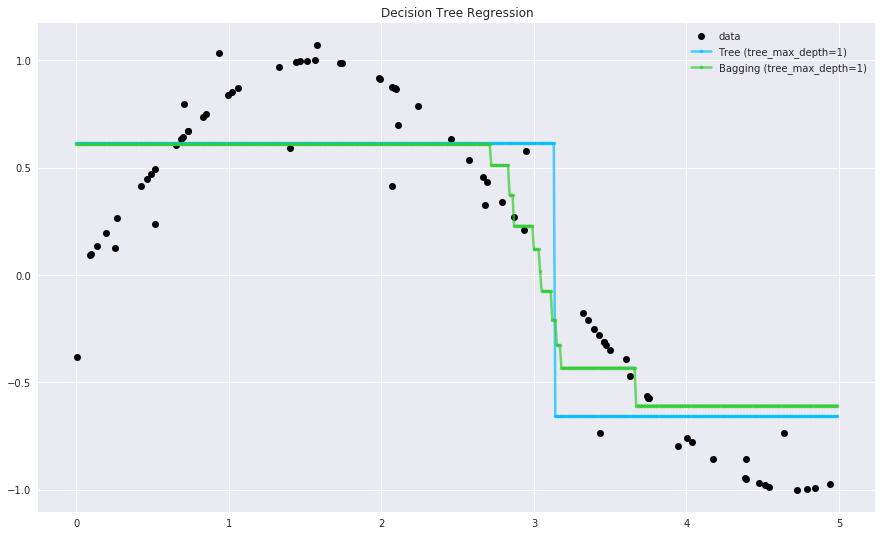

In [125]:
plot_tree_bag(X=X, y=y, X_test=X_test, L=10, tree_max_depth=1, bagging_max_depth=10)

> Pour une profondeur d'arbre égale à 1, les modèles d'arbre de décision et de bagging ne prédisent pas suffisament les données. La forme des courbes de résultat obtenues ne correpond pas au jeu de données sur lequel on a testé. Les modèles sous-apprennent.

> Testons donc avec une profondeur d'arbre plus élevée :

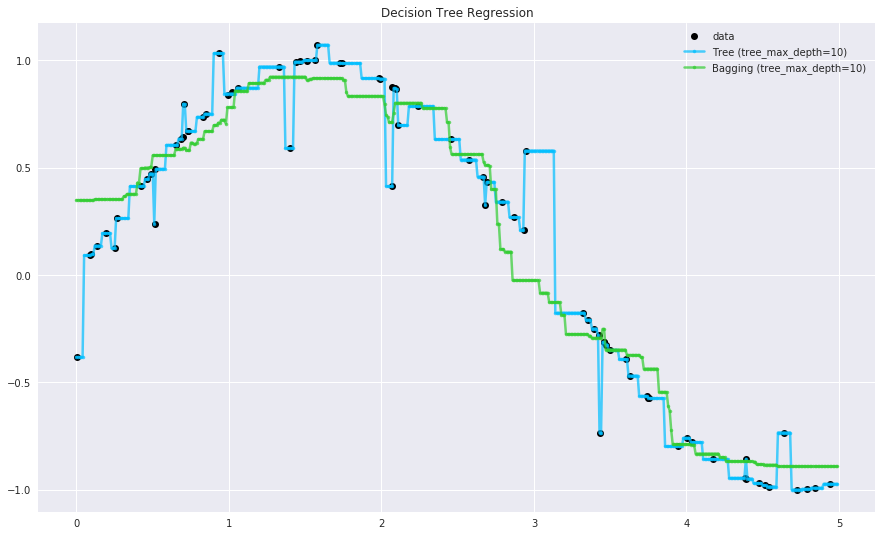

In [127]:
plot_tree_bag(tree_max_depth=10)

>Contrairement au cas précédent où les courbes ne s'ajustaient pas aux données, les coubres obtenues avec une profondeur égale à 10 restituent très bien le comportement des données. On peut en effet voir l'allure sinusoidale des courbes. En particulier, les modèles prennent en compte les points bruités. On peut se demander si les modèles non pas sur-appris sur nos données d'apprentissage (**overfitting**).

>Par la suite, il faudra étudier comment ajuster les hyperparamètres tels que le nombre d'estimateurs L ou la profondeur maximale de l'arbre pour obtenir des modèles estimant correctement nos données, et limitant les cas critiques d'underfitting et d'overfitting :

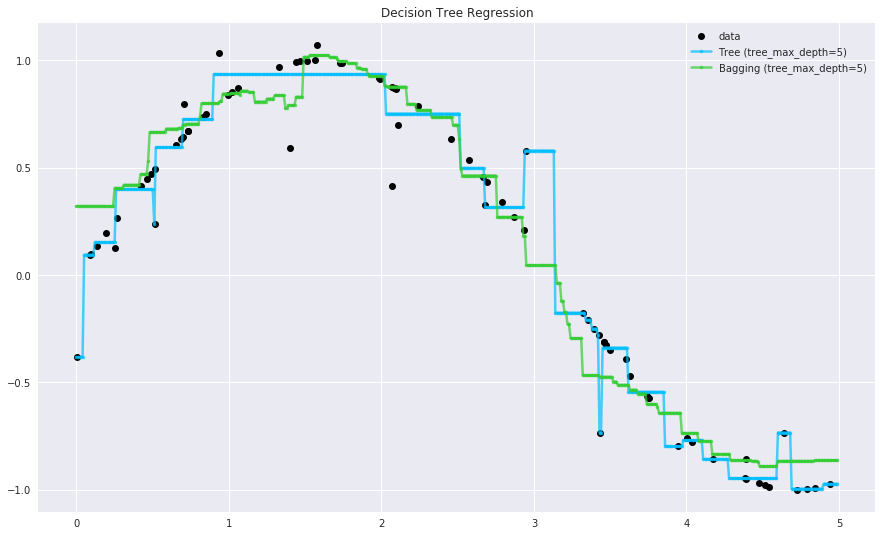

In [128]:
plot_tree_bag(tree_max_depth=5)

> C'est un peu mieux avec un profondeur d'arbre égale à 5.

> Et en faisant varier la profondeur du Bagging :

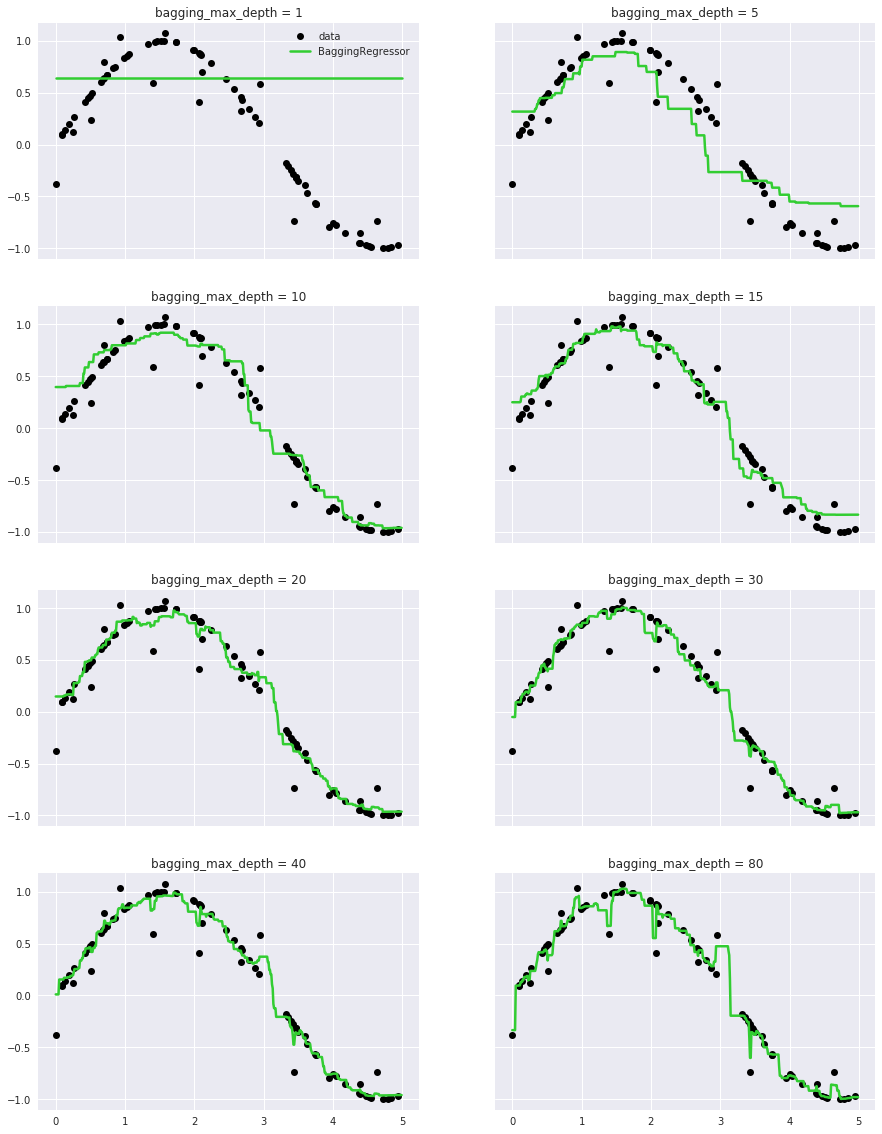

In [126]:
sample_depths = [1, 5, 10, 15, 20, 30, 40, len(X)]

# for plots
fig, axs = plt.subplots(int(len(sample_depths)/2), 2, facecolor='w', edgecolor='k', sharex='col', sharey='row', figsize=(15,20))

index = 0
for i in range(int(len(sample_depths)/2)): # test all max_sample
    for j in range(2):
        bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=10), 
                                   n_estimators = 10, max_samples=sample_depths[index])
        bagging.fit(X, y)

        # predictions
        y_pred = bagging.predict(X_test)

        # plot everything
        axs[i][j].plot(X, y, 'o', c="k", label="data")
        axs[i][j].plot(X_test, y_pred, c=c_bagging_bt, linewidth=lw, label="BaggingRegressor")
        axs[i][j].set_title("bagging_max_depth = %d"%(sample_depths[index]))
        index += 1
        
axs[0][0].legend()   
plt.show()

### Question 3 :
Illustrer graphiquement le rôle de $L$ ainsi que de la profondeur des arbres (`max_depth`) en jouant sur ces deux paramètres.

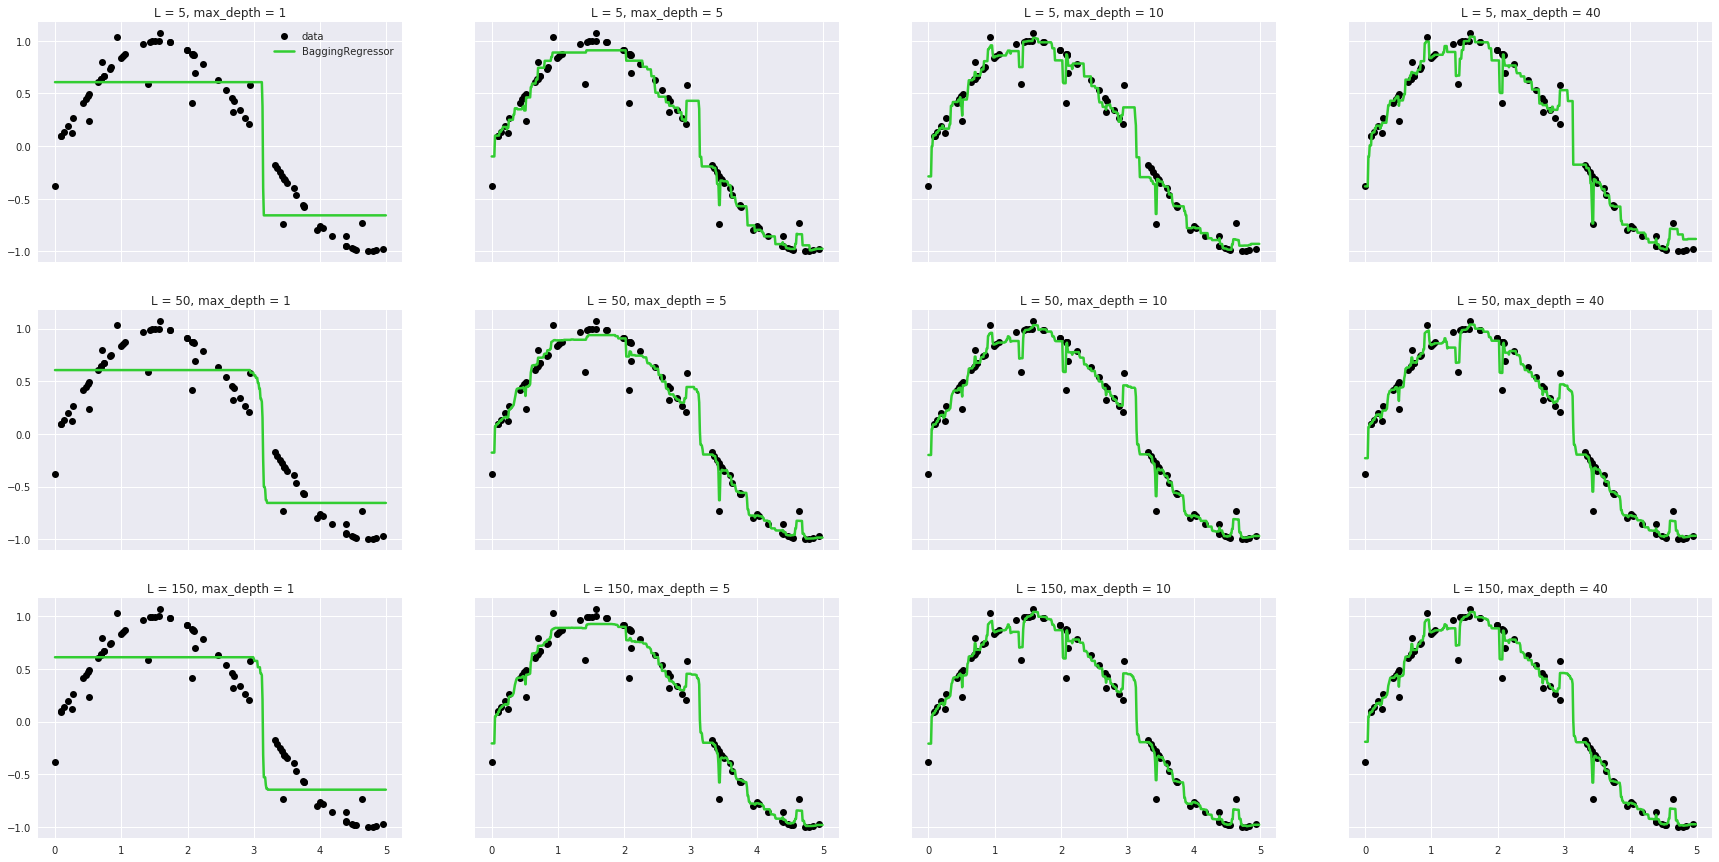

In [132]:
# The result we ideally expect to have
y_test = np.sin(X_test).ravel()

Ls = [5, 50, 150]
depths = [1, 5, 10, 40]

# Create a double loop for L and max_depth
scores = np.zeros((len(Ls), len(depths))) # create a matrix to store the scores. Rows = L, Columns = max_depth
baggings = [] # store the models

# for plots
fig, axs = plt.subplots(len(Ls), len(depths), facecolor='w', edgecolor='k', sharex='col', sharey='row', figsize=(30,15))

for i, l in enumerate(Ls, 0): # test all Ls
    #print("Setting L=%d" %l)
    for j, d in enumerate(depths, 0): # test all depths
        #print("    | Setting max_depth=%d" %d)
        bagging = BaggingRegressor(base_estimator=DecisionTreeRegressor(max_depth=d), 
                                   n_estimators = l)
        bagging.fit(X, y)
        scores[i, j] = bagging.score(X_test, y_test)
        baggings.append(bagging)
        
        # predictions
        y_pred = bagging.predict(X_test)
        
        # plot everything
        axs[i][j].plot(X, y, 'o', c="k", label="data")
        axs[i][j].plot(X_test, y_pred, c=c_bagging_bt, linewidth=lw, label="BaggingRegressor")
        axs[i][j].set_title("L = %d, max_depth = %d"%(l, d))
        
axs[0][0].legend()   
plt.show()

>Les graphiques ci-dessus permettent d'observer l'impact des paramètres $L$ et $max_depth$ sur les modèles. Pour une ligne fixée, on fait ainsi varier la profondeur des arbres, tandis que pour une colonne fixée, on fait varier $L$.

>Au fur et à mesure que l'on augmente $L$ (en regardant les figures le long d'une colonne donnée et de haut en bas), l'allure de la courbe semble conservée mais se trouve **lissée**;

>Plus on fait varier la profondeur, plus le modèle est précis, l'allure sinusoidale de la courbe apparaît davantage. En faisant varier la profondeur de 5 à 15, on observe en effet l'évolution de la courbe et son ajustement aux données, mais en risquant l'overfitting.

>Pour une profondeur faible, égale à 1, le modèle n'est pas proche des données : **le biais est élevé**.
>Pour une profondeur supérieure à 10, le modèle sur-apprend : la variance est élevée. **La profondeur de l'arbre permet de modifier la variance**.

### Question 4 :
A quoi reconnaît-on que les estimateurs construits par les arbres sont biaisés et que le *bagging* réduit leur variance ?

>Nous avons pu voir dans la question précédente que des valeurs élevées de L et de la profondeur d'arbre peuvent faire varier de manière significative les prédictions sur un jeu de données test.

>En régression, le risque d'un estimateur se décompose suivant le biais, la variance et le bruit.

>La variance exprime la variabilité des prédictions d'un estimateur sur différentes instances du problème. **Dans le cas des arbres de décision, la profondeur de l'arbre détermine la variance**.

>* Pour une **faible valeur de profondeur d'arbre** (par exemple `max_depth = 1`), le **biais est élevé** : les abres ne peuvent pleinement approximer les données, mais la variance entre les différents essais est faible.
* Lorsque la **profondeur augmente, le biais diminue** : les courbes obtenues se rapprochent davantage du jeu de données test. Cependant, les modèles d'arbres sont désormais sensibles données, en particulier si celles-ci sont bruitées : **la variance est plus grande**.

> ***Le bagging permet de d'agréger les arbres, et donc de réduire la sensibilité aux variations. La variance est ainsi plus faible qu'avec un arbre de décision seul.***

### Question 5 : 
En jouant sur le niveau de bruit, mettez en évidence le sur-apprentissage.

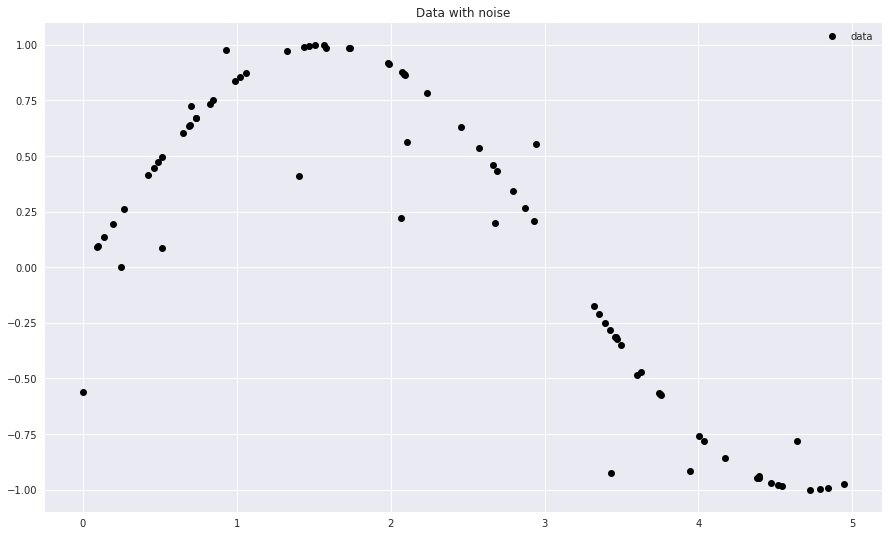

In [148]:
# Start with the random dataset again
rng = np.random.RandomState(1)
X = np.sort(5 * rng.rand(80, 1), axis=0)
y = np.sin(X).ravel()

def generate_noise(X, s=0.5):
    y_noise = np.sin(X).ravel()
    y_noise[::5] += 1 * (0.5 - s*rng.rand(16))
    return y_noise

# Plot the results
y_noise = generate_noise(X, s=1.2)
plt.figure(figsize=(15, 9))
plt.plot(X, y_noise, 'o', c="k", label="data")

plt.title("Data with noise")
plt.legend(loc=1, numpoints=1)
plt.show()

In [156]:
# Create a noise list with different noise values
noise_list = np.arange(0.5, 2, 0.2)
noise_list

array([0.5, 0.7, 0.9, 1.1, 1.3, 1.5, 1.7, 1.9])

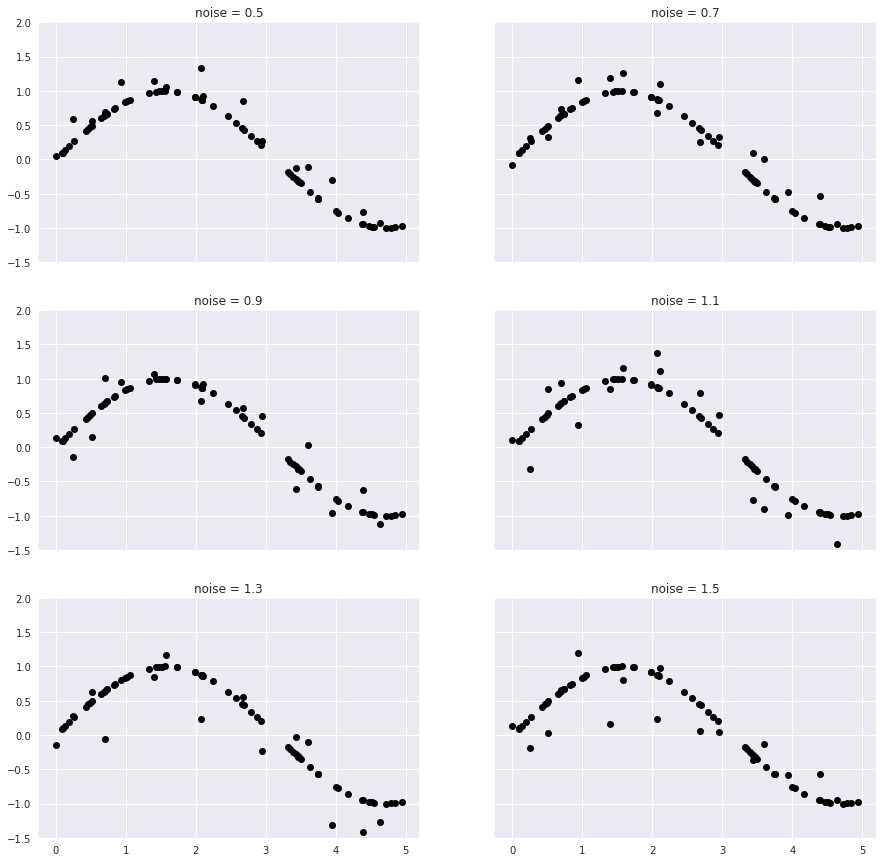

In [157]:
# Generate y with these noises
y_list = [generate_noise(X, s=n) for n in noise_list]

# Generate multiple data with noise
fig, axs = plt.subplots(3, 2, facecolor='w', edgecolor='k', sharex='col', sharey='row', figsize=(15,15))

noise = 0
for i in range(3):
    j= 0 
    for p in y_list[2*i:2*(i+1)]:
        axs[i][j].plot(X, p, 'o', c="k")
        axs[i][j].set_title("noise = %.1f" %noise_list[noise])
        axs[i][j].set_ylim(-1.5, 2.0)
        j += 1
        
        noise+=1

plt.show()

>Ces nouvelles données vont nous servir à tester nos arbres de décision et à mettre en évidence le sur-apprentissage.

In [158]:
# Create a fitted tree for each y_noise
def fit_noise(X, y_list, max_depth=10):

    tree_noise = []

    for y in y_list:
        tree = DecisionTreeRegressor(max_depth=max_depth)
        tree.fit(X, y)
        tree_noise.append(tree)

    return tree_noise

tree_noise = fit_noise(X, y_list)

In [160]:
# Plot
def plot_noise(X, X_test, tree_noise, y_list):
    # 2 columns
    if (len(tree_noise) % 2 == 0):
        print("Number of plots : even")
        n_rows = int(len(tree_noise) / 2)
    else: 
        print("Number of plots : odd")
        n_rows = int(len(tree_noise) / 2) + 1
    print("Number of rows :", n_rows)
    
    fig, axs = plt.subplots(n_rows, 2, facecolor='w', edgecolor='k', sharex='col', sharey='row', figsize=(20, 20))
    
    noise = 0
    for i in range(n_rows):
        print("Line ", i)
        j = 0
        for tree in tree_noise[2*i:2*(i+1)]:
            axs[i][j].plot(X, y_list[noise], 'o', c="k")
            axs[i][j].plot(X_test, tree.predict(X_test), alpha=alp, color=c_tree, linewidth=lw)
            title = 'noise = %.1f (max_depth=%d)' %(noise_list[noise], tree.max_depth)
            axs[i][j].set_title(title)
            axs[i][j].set_ylim(-1.5, 2.0)
        
            j += 1
            noise += 1


    plt.show()

Number of plots : even
Number of rows : 4
Line  0
Line  1
Line  2
Line  3


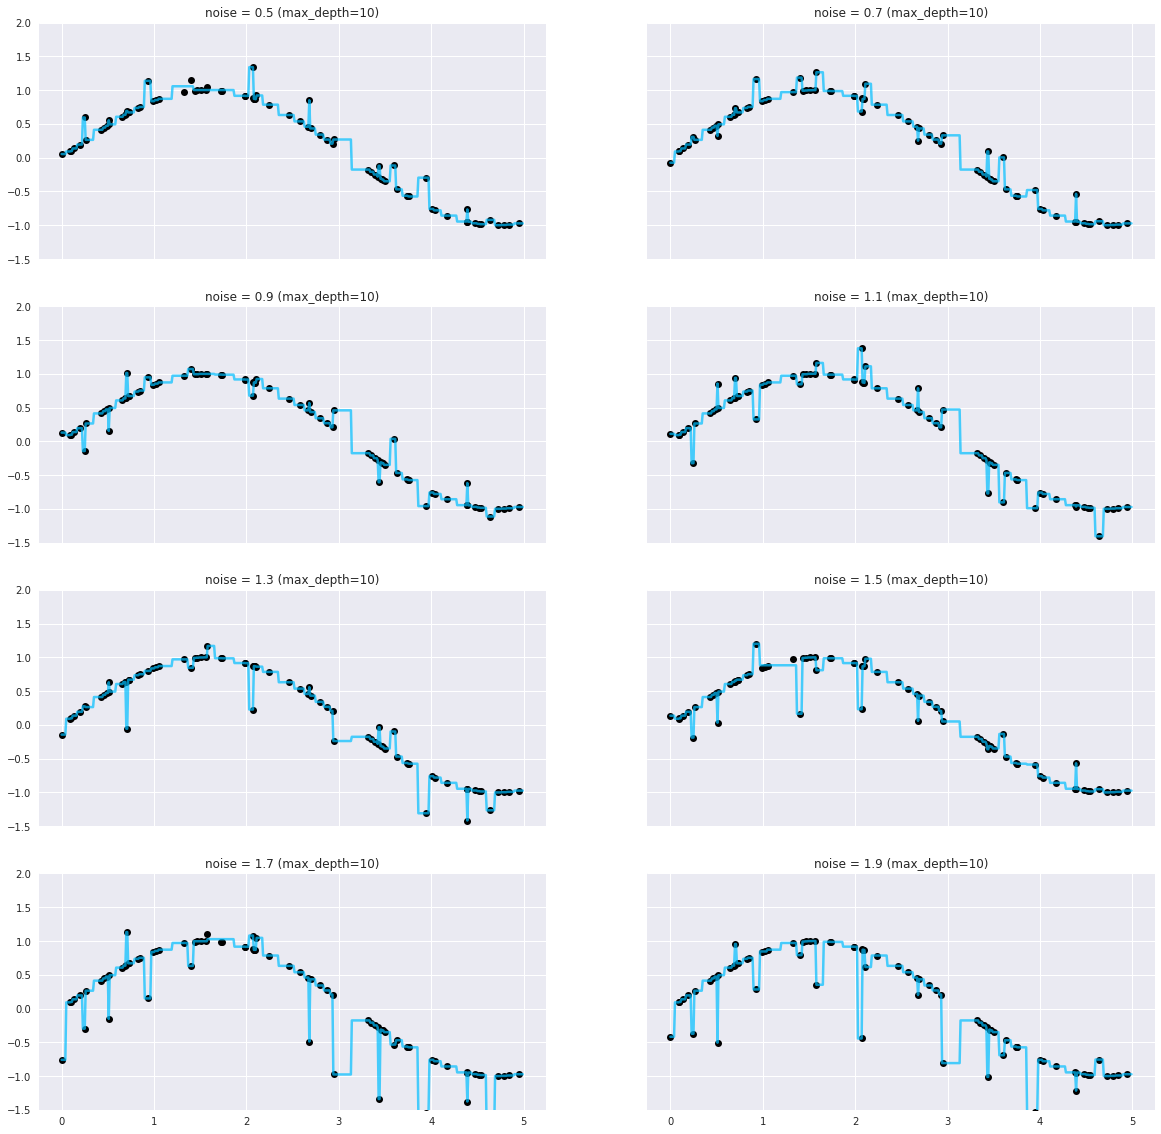

In [161]:
plot_noise(X, X_test, tree_noise, y_list)

>Pour une profondeur d'arbre égale à 10, on remarque effectivement que pour différents jeux de données bruités, sur lequel on entraine un arbre de décision, le modèle obtenu sur-apprend et suit le motif des données de départ. **Le modèle est donc sensible au bruit.*

### Question 6 :
Observer qu'on peut réduire ce phénomène en sous-échantillonnant aléatoirement (sans remise) au lieu de prendre des échantillons *bootstrap*.

https://github.com/thaiantt/Cours/blob/master/P2/MDI343/TP/Bagging/TP_Bagging.ipynb